In [1]:
!pip install -q transformers datasets accelerate sentencepiece wandb shap nltk scikit-learn matplotlib wordcloud

import os
os.environ["WANDB_DISABLED"] = "true"


In [2]:
from google.colab import drive
drive.mount('/content/drive')


local_path_1 = "/content/Philippine_Business_TrustPilot_Reviews_Labeled (2).csv"
drive_path_example = "/content/drive/MyDrive/TrustPilot/Philippine_Business_TrustPilot_Reviews_Labeled (2).csv"

import os
csv_path = local_path_1 if os.path.exists(local_path_1) else drive_path_example
print("Using CSV:", csv_path)


Mounted at /content/drive
Using CSV: /content/drive/MyDrive/TrustPilot/Philippine_Business_TrustPilot_Reviews_Labeled (2).csv


In [3]:
import pandas as pd
df = pd.read_csv(csv_path)
print("Rows:", len(df))
df.head()


Rows: 10916


,Business Name,Business Average Rating,Business Review Grade,User Review Title,User Review Body,User Review Rating,User Review Date,User Review Count,User Country,User Review Status,User Review Month,User Review Year,Ground Label
0,Mabuhay Travel,4.9,Excellent,Excellent Service - Kathleen Gomez,"""HUGE THANK YOU KATHLEEN GOMEZ FOR YOUR EXCELL...",5,24-Nov-18,1,GB,NaN,Nov,2018,Positive
1,Singlife Philippines,4.6,Excellent,"""What I can say for now.""","""It was my first time to avail of Singlife's P...",4,"Updated Oct. 29, 2021",1,PH,Updated,Oct,2021,Positive
2,PNXBET,4.8,Excellent,#1 Betting site here in our country…,#1 Betting site here in our country good 24/7 ...,5,27-Dec-21,1,PH,NaN,Dec,2021,Positive
3,PNXBET,4.8,Excellent,#1 betting site The One and Only…,#1 betting site The One and Only #PNXBET for t...,5,27-Dec-21,1,PH,NaN,Dec,2021,Positive
4,PNXBET,4.8,Excellent,#1 betting site in the Philippines more…,#1 betting site in the Philippines more crazy ...,5,26-Dec-21,1,PH,NaN,Dec,2021,Positive


In [4]:
import numpy as np
import re

def safe_str(x):
    return "" if pd.isna(x) else str(x)

df['text'] = df['User Review Title'].fillna("").map(safe_str) + " . " + df['User Review Body'].fillna("").map(safe_str)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

print(df['User Review Rating'].value_counts(dropna=False))
if 'Ground Label' in df.columns:
    print("Ground Label sample values:", df['Ground Label'].value_counts(dropna=False).head())
df = df.dropna(subset=['text'])  # drop rows without text


User Review Rating
5    6506
1    3317
4     675
3     218
2     200
Name: count, dtype: int64
Ground Label sample values: Ground Label
Positive    7181
Negative    3517
Neutral      218
Name: count, dtype: int64


In [5]:


def auto_label_fake(row, duplicates_set):
    text = row['text'].lower()
    # short or extremely long
    if len(text) < 20 or len(text) > 3000:
        return "fake"
    # user with only 1 review
    try:
        urc = int(row.get('User Review Count', 0))
    except:
        urc = 0
    if urc == 1:
        score = 1
    else:
        score = 0

    promo_keywords = ['#1', 'best', 'top', 'best in', 'only one', 'guaranteed', 'win', 'jackpot', 'promo']
    if any(pk in text for pk in promo_keywords):
        score += 1

    if text.count('!') >= 5 or (sum(1 for c in text if c.isupper()) > len(text)*0.5):
        score += 1

    if text in duplicates_set:
        score += 2
    return "fake" if score >= 2 else "real"

text_counts = df['text'].value_counts()
duplicates = set(text_counts[text_counts > 1].index.tolist())

df['auto_label_fake'] = df.apply(lambda r: auto_label_fake(r, duplicates), axis=1)
print("Auto-label counts:", df['auto_label_fake'].value_counts())


Auto-label counts: auto_label_fake
real    9515
fake    1401
Name: count, dtype: int64


In [6]:

def rating_to_sentiment(r):
    try:
        r = float(r)
    except:
        return "neutral"
    if r >= 4.0:
        return "positive"
    elif r == 3.0:
        return "neutral"
    else:
        return "negative"

df['sentiment_label'] = df['User Review Rating'].apply(lambda r: rating_to_sentiment(r))
print(df['sentiment_label'].value_counts())


sentiment_label
positive    7181
negative    3517
neutral      218
Name: count, dtype: int64


In [7]:

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


df_fake = df[['text','auto_label_fake']].rename(columns={'auto_label_fake':'label'})
df_fake['label_id'] = df_fake['label'].map({'real':0, 'fake':1})


df_sent = df[['text','sentiment_label']].rename(columns={'sentiment_label':'label'})
sent_map = {'negative':0,'neutral':1,'positive':2}
df_sent['label_id'] = df_sent['label'].map(sent_map)


def make_hf_datasets(df_local, label_col='label_id', test_size=0.15, seed=42):
    tr, te = train_test_split(df_local, test_size=test_size, stratify=df_local[label_col], random_state=seed)
    tr, val = train_test_split(tr, test_size=0.12, stratify=tr[label_col], random_state=seed)
    ds = DatasetDict({
        'train': Dataset.from_pandas(tr.reset_index(drop=True)),
        'validation': Dataset.from_pandas(val.reset_index(drop=True)),
        'test': Dataset.from_pandas(te.reset_index(drop=True))
    })
    return ds

ds_fake = make_hf_datasets(df_fake, 'label_id')
ds_sent = make_hf_datasets(df_sent, 'label_id')

print("Fake dataset sizes:", {k:len(ds_fake[k]) for k in ds_fake})
print("Sentiment dataset sizes:", {k:len(ds_sent[k]) for k in ds_sent})


Fake dataset sizes: {'train': 8164, 'validation': 1114, 'test': 1638}
Sentiment dataset sizes: {'train': 8164, 'validation': 1114, 'test': 1638}


In [8]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

ds_fake_tokenized = ds_fake.map(tokenize_fn, batched=True).remove_columns(['text', 'label'])
ds_fake_tokenized = ds_fake_tokenized.rename_column("label_id", "labels")

ds_sent_tokenized = ds_sent.map(tokenize_fn, batched=True).remove_columns(['text', 'label'])
ds_sent_tokenized = ds_sent_tokenized.rename_column("label_id", "labels")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8164 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

Map:   0%|          | 0/8164 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def compute_metrics_fake(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='binary'),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary')
    }

def compute_metrics_sent(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
    }


In [10]:
model_fake = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args_fake = TrainingArguments(
    output_dir="./distil_fake",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.05,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer_fake = Trainer(
    model=model_fake,
    args=training_args_fake,
    train_dataset=ds_fake_tokenized["train"],
    eval_dataset=ds_fake_tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_fake
)

trainer_fake.train()
fake_metrics = trainer_fake.evaluate(ds_fake_tokenized["test"])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2669240409.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fake = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.188600,0.205039,0.925494,0.695971,0.730769,0.664336
2,0.163300,0.186011,0.932675,0.733096,0.746377,0.720280
3,0.236400,0.180707,0.938061,0.735632,0.813559,0.671329


In [11]:
model_save_dir_fake = "/content/drive/MyDrive/TrustPilot_models/distil_fake"
model_save_dir_sent = "/content/drive/MyDrive/TrustPilot_models/distil_sent"

trainer_fake.save_model(model_save_dir_fake)
tokenizer.save_pretrained(model_save_dir_fake)

('/content/drive/MyDrive/TrustPilot_models/distil_fake/tokenizer_config.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_fake/special_tokens_map.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_fake/vocab.txt',
 '/content/drive/MyDrive/TrustPilot_models/distil_fake/added_tokens.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_fake/tokenizer.json')

In [12]:
model_sent = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args_sent = TrainingArguments(
    output_dir="./distil_sent",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.05,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

trainer_sent = Trainer(
    model=model_sent,
    args=training_args_sent,
    train_dataset=ds_sent_tokenized["train"],
    eval_dataset=ds_sent_tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_sent
)

trainer_sent.train()
sent_metrics = trainer_sent.evaluate(ds_sent_tokenized["test"])

trainer_sent.save_model(model_save_dir_sent)
tokenizer.save_pretrained(model_save_dir_sent)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-458312807.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_sent = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.182700,0.111963,0.964093,0.647333
2,0.089300,0.144279,0.961400,0.709801
3,0.061800,0.121744,0.969479,0.790944


('/content/drive/MyDrive/TrustPilot_models/distil_sent/tokenizer_config.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_sent/special_tokens_map.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_sent/vocab.txt',
 '/content/drive/MyDrive/TrustPilot_models/distil_sent/added_tokens.json',
 '/content/drive/MyDrive/TrustPilot_models/distil_sent/tokenizer.json')

In [13]:
from transformers import pipeline

pipe_fake = pipeline("text-classification", model=model_save_dir_fake, tokenizer=model_save_dir_fake, return_all_scores=True, max_length=max_length, truncation=True)
pipe_sent = pipeline("text-classification", model=model_save_dir_sent, tokenizer=model_save_dir_sent, return_all_scores=True, max_length=max_length, truncation=True)

def predict_fake(texts):
    return pipe_fake(texts)

def predict_sentiment(texts):
    return pipe_sent(texts)


sample_text = df['text'].iloc[0]
print("Sample text:", sample_text[:200])
print("Fake prediction:", predict_fake(sample_text))
print("Sent prediction:", predict_sentiment(sample_text))

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cuda:0


Sample text: Excellent Service - Kathleen Gomez . "HUGE THANK YOU KATHLEEN GOMEZ FOR YOUR EXCELLENT RELIABLE SERVICE." YOU'RE SO POLITE AND VERY PLEASANT TO TALK TO. YOU GAVE US A GREAT DEAL INDEED. I WILL DEFINIT
Fake prediction: [[{'label': 'LABEL_0', 'score': 0.9946969747543335}, {'label': 'LABEL_1', 'score': 0.00530298100784421}]]
Sent prediction: [[{'label': 'LABEL_0', 'score': 0.0013626774307340384}, {'label': 'LABEL_1', 'score': 0.001202302286401391}, {'label': 'LABEL_2', 'score': 0.9974350333213806}]]


In [14]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# 1) Flag suspicious businesses (high fake rate)
df['pred_fake_proba'] = [p[1]['score'] if isinstance(p, list) and len(p)>1 else 0.0 for p in predict_fake(df['text'].tolist())]
df['pred_fake_label'] = df['pred_fake_proba'].apply(lambda x: 'fake' if x >= 0.5 else 'real')

business_groups = df.groupby('Business Name')
suspicious_summary = []
for b, g in business_groups:
    total = len(g)
    fake_count = (g['pred_fake_label'] == 'fake').sum()
    fake_rate = fake_count / total
    suspicious_summary.append((b, total, fake_count, fake_rate))
sus_df = pd.DataFrame(suspicious_summary, columns=['Business','TotalReviews','FakeReviews','FakeRate']).sort_values('FakeRate', ascending=False)
display(sus_df.head(20))

# 2) Top complaint keywords for businesses with many negative reviews
neg = df[df['sentiment_label']=='negative']
def get_top_terms(series, n=20):
    tokens = []
    for t in series:
        words = re.findall(r'\w+', str(t).lower())
        words = [w for w in words if w not in stop and len(w)>2]
        tokens.extend(words)
    return Counter(tokens).most_common(n)

top_terms_overall = get_top_terms(neg['text'])
print("Top negative terms overall:", top_terms_overall[:20])

df['User Review Date parsed'] = pd.to_datetime(df['User Review Date'], errors='coerce')
df['week'] = df['User Review Date parsed'].dt.to_period('W').astype(str)
burst_summaries = []
for b, g in df.groupby('Business Name'):
    counts_by_week = g.groupby('week').size().sort_values(ascending=False)
    if len(counts_by_week) > 0 and counts_by_week.iloc[0] >= 10 and counts_by_week.iloc[0] > counts_by_week.iloc[1] * 3 if len(counts_by_week)>1 else False:
        burst_summaries.append((b, counts_by_week.index[0], int(counts_by_week.iloc[0])))
burst_df = pd.DataFrame(burst_summaries, columns=['Business','BurstWeek','Count']).sort_values('Count', ascending=False)
display(burst_df.head(20))

top_suspicious = sus_df[sus_df['TotalReviews']>=20].head(10)  # require some volume
for idx,row in top_suspicious.iterrows():
    bname = row['Business']
    print("----")
    print(f"Business: {bname}")
    print(f"Total Reviews: {row['TotalReviews']}, Predicted Fake Rate: {row['FakeRate']:.2%}")
    g = df[df['Business Name']==bname]
    pos = (g['sentiment_label']=='positive').sum()
    negc = (g['sentiment_label']=='negative').sum()
    print(f"Sentiment split — Positive: {pos}, Negative: {negc}")
    print("Top complaint words:", get_top_terms(g[g['sentiment_label']=='negative']['text'], n=10))
    # simple recommendation
    print("Recommendation: Investigate sudden positive-review bursts, check user accounts with single review, and prioritize addressing the top complaint items above.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Business,TotalReviews,FakeReviews,FakeRate
10,PNXBET,1261,328,0.260111
5,Learn to Trade Philippines,170,38,0.223529
14,Shopee,152,28,0.184211
4,Lazada,508,87,0.171260
2,Globe Telecom,736,118,0.160326
3,LBC Express,252,38,0.150794
13,Sendflowerstophilippines,154,22,0.142857
9,PLDT,658,89,0.135258
7,Moneymax,372,49,0.131720
8,Ninja Van,427,52,0.121780


Top negative terms overall: [('service', 2642), ('customer', 1571), ('delivery', 1406), ('even', 1137), ('internet', 1132), ('time', 1042), ('lazada', 1019), ('company', 996), ('worst', 939), ('order', 938), ('get', 843), ('globe', 830), ('day', 768), ('never', 762), ('one', 758), ('bad', 745), ('money', 740), ('still', 685), ('pldt', 682), ('item', 670)]


/tmp/ipython-input-2314444135.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['User Review Date parsed'] = pd.to_datetime(df['User Review Date'], errors='coerce')


,Business,BurstWeek,Count
3,Mabuhay Travel,NaT,177
8,THEKULT.COM,2020-03-09/2020-03-15,171
2,Lazada,NaT,150
0,Globe Telecom,NaT,97
5,PLDT,NaT,83
1,LBC Express,NaT,54
4,Ninja Van,NaT,53
6,PawnHero & Marketplace,NaT,23
7,Shopee,NaT,22


----
Business: PNXBET
Total Reviews: 1261, Predicted Fake Rate: 26.01%
Sentiment split — Positive: 1207, Negative: 46
Top complaint words: [('money', 41), ('account', 23), ('site', 18), ('scam', 15), ('pnxbet', 15), ('withdraw', 14), ('bet', 11), ('deposit', 11), ('even', 11), ('betting', 11)]
Recommendation: Investigate sudden positive-review bursts, check user accounts with single review, and prioritize addressing the top complaint items above.
----
Business: Learn to Trade Philippines
Total Reviews: 170, Predicted Fake Rate: 22.35%
Sentiment split — Positive: 165, Negative: 3
Top complaint words: [('avoid', 2), ('bad', 2), ('customer', 2), ('service', 2), ('philippines', 2), ('company', 2), ('good', 2), ('true', 2), ('money', 2), ('ask', 2)]
Recommendation: Investigate sudden positive-review bursts, check user accounts with single review, and prioritize addressing the top complaint items above.
----
Business: Shopee
Total Reviews: 152, Predicted Fake Rate: 18.42%
Sentiment split — P

### Model Evaluation Metrics

In [15]:
import pandas as pd

fake_metrics_df = pd.DataFrame([fake_metrics])
sent_metrics_df = pd.DataFrame([sent_metrics])

print("--- Fake Review Detector Test Metrics ---")
display(fake_metrics_df)

print("--- Sentiment Analysis Test Metrics ---")
display(sent_metrics_df)

--- Fake Review Detector Test Metrics ---


,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.172444,0.940171,0.755,0.794737,0.719048,12.3046,133.121,2.113,3.0


--- Sentiment Analysis Test Metrics ---


,eval_loss,eval_accuracy,eval_f1_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.164762,0.959096,0.71027,12.2147,134.1,2.129,3.0


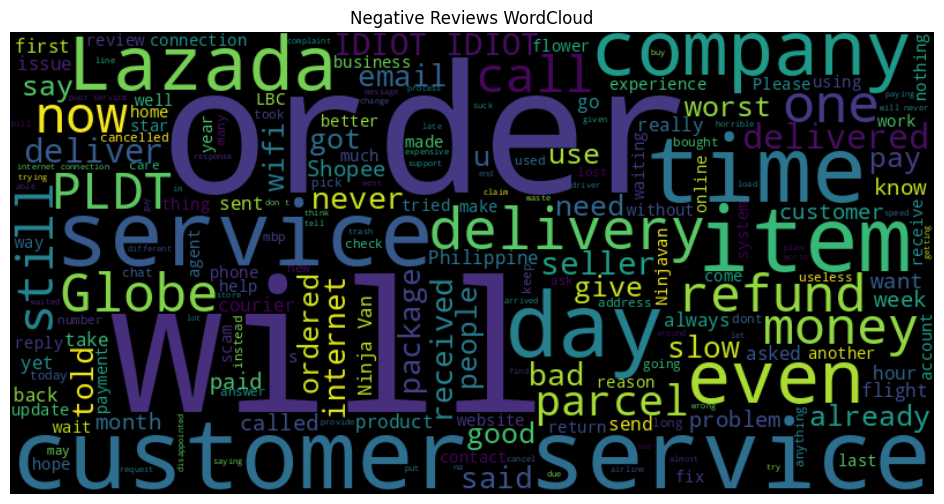

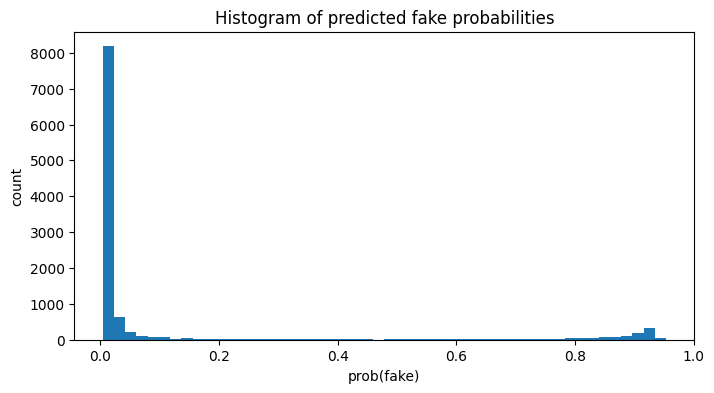

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


neg_text = " ".join(neg['text'].astype(str).tolist())
wc = WordCloud(width=800, height=400).generate(neg_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['pred_fake_proba'].fillna(0), bins=50)
plt.title("Histogram of predicted fake probabilities")
plt.xlabel("prob(fake)")
plt.ylabel("count")
plt.show()

In [17]:
insights_out = df[['Business Name','text','User Review Rating','sentiment_label','pred_fake_proba','pred_fake_label','User Review Date']]
out_path = "/content/drive/MyDrive/TrustPilot_insights.csv"
insights_out.to_csv(out_path, index=False)
print("Saved insights to", out_path)

Saved insights to /content/drive/MyDrive/TrustPilot_insights.csv


In [18]:
from IPython.display import display
import ipywidgets as widgets

pipe_fake = pipeline("text-classification", model=model_save_dir_fake, tokenizer=model_save_dir_fake, return_all_scores=True, max_length=max_length, truncation=True)
pipe_sent = pipeline("text-classification", model=model_save_dir_sent, tokenizer=model_save_dir_sent, return_all_scores=True, max_length=max_length, truncation=True)


text_input = widgets.Textarea(
    value='',
    placeholder='Type or paste a review here...',
    description='Review:',
    layout=widgets.Layout(width='100%', height='120px')
)

run_button = widgets.Button(
    description='Run Prediction',
    button_style='success',
    tooltip='Click to run prediction'
)

output_box = widgets.Output()

def on_button_clicked(b):
    output_box.clear_output()

    text = text_input.value.strip()
    if not text:
        with output_box:
            print(" Please type a review before running.")
        return

    with output_box:
        print("Running prediction...\n")


        model_choice_value = 'both'

        if model_choice_value in ['fake', 'both']:
            fake_output = pipe_fake(text)[0]
            fake_label_raw = max(fake_output, key=lambda x: x['score'])['label']
            fake_score = max(fake_output, key=lambda x: x['score'])['score']

            fake_label = "REAL" if fake_label_raw == "LABEL_0" else "FAKE"
            print(f" Fake Review Detector:")
            print(f"   → Predicted: **{fake_label}**")
            print(f"   → Confidence: {fake_score:.4f}\n")

        if model_choice_value in ['sent', 'both']:
            sent_output = pipe_sent(text)[0]
            sent_label_raw = max(sent_output, key=lambda x: x['score'])['label']
            sent_score = max(sent_output, key=lambda x: x['score'])['score']

            if sent_label_raw == "LABEL_0":
                sent_label = "NEGATIVE"
            elif sent_label_raw == "LABEL_1":
                sent_label = "NEUTRAL"
            else:
                sent_label = "POSITIVE"
            print(f" Sentiment Analysis:")
            print(f"   → Sentiment: **{sent_label}**")
            print(f"   → Confidence: {sent_score:.4f}\n")

run_button.on_click(on_button_clicked)

display(text_input)
display(run_button)
display(output_box)

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cuda:0


Textarea(value='', description='Review:', layout=Layout(height='120px', width='100%'), placeholder='Type or pa…

Button(button_style='success', description='Run Prediction', style=ButtonStyle(), tooltip='Click to run predic…

Output()